In [ ]:
import json
import re
import numpy as np
from itertools import combinations
import random as rd
from sklearn.utils import shuffle
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from tabulate import tabulate


In [ ]:
# Load the JSON data file
with open('/content/TVs-all-merged.json') as f:
  data = json.load(f)

print(type(data))

print(data)
#print(data)

<class 'dict'>
{'29PFL4508/F7': [{'shop': 'bestbuy.com', 'url': 'http://www.bestbuy.com/site/Philips+-+4000+Series+-+29%26%2334%3B+Class+(28-1/2%26%2334%3B+Diag.)+-+LED+-+720p+-+60Hz+-+HDTV/9806538.p;template=_specificationsTab', 'modelID': '29PFL4508/F7', 'featuresMap': {'Screen Size Class': '29"', 'DVI Inputs': '0', 'ENERGY STAR Certified': 'Yes', 'Ethernet Port': 'No', 'Sleep Timer': 'Yes', 'Width': '27 inches', 'USB Port': 'Yes', 'TV Type': 'LED Flat-Panel', 'V-Chip': 'Yes', 'Component Video Inputs': '1', 'UPC': '609585230651', 'Screen Size (Measured Diagonally)': '28-1/2"', 'Mount Bracket/VESA Pattern': '100mm x 100mm', 'PC Inputs': '1', 'Aspect Ratio': '4:3 and 16:9', 'Audio Outputs': '1', 'Sound Leveler': 'Yes', 'Media Card Slot': 'No', 'Weight': '12.1 lbs. with stand (10.6 lbs. without)', 'Vertical Resolution': '720p', 'Composite Inputs': '1', 'Brightness': '270 cd/mÂ²', 'Watts/Channel': '8', 'HDMI Inputs': '3', 'Maximum Resolution': '1366 x 768', 'Screen Refresh Rate': '60Hz',

In [ ]:
descriptions = {}
i = 1
for key in data.keys():
    for description in data[key]:
        descriptions[i] = description
        i+=1
print(len(descriptions.keys()))
print(descriptions)

1624
{1: {'shop': 'bestbuy.com', 'url': 'http://www.bestbuy.com/site/Philips+-+4000+Series+-+29%26%2334%3B+Class+(28-1/2%26%2334%3B+Diag.)+-+LED+-+720p+-+60Hz+-+HDTV/9806538.p;template=_specificationsTab', 'modelID': '29PFL4508/F7', 'featuresMap': {'Screen Size Class': '29"', 'DVI Inputs': '0', 'ENERGY STAR Certified': 'Yes', 'Ethernet Port': 'No', 'Sleep Timer': 'Yes', 'Width': '27 inches', 'USB Port': 'Yes', 'TV Type': 'LED Flat-Panel', 'V-Chip': 'Yes', 'Component Video Inputs': '1', 'UPC': '609585230651', 'Screen Size (Measured Diagonally)': '28-1/2"', 'Mount Bracket/VESA Pattern': '100mm x 100mm', 'PC Inputs': '1', 'Aspect Ratio': '4:3 and 16:9', 'Audio Outputs': '1', 'Sound Leveler': 'Yes', 'Media Card Slot': 'No', 'Weight': '12.1 lbs. with stand (10.6 lbs. without)', 'Vertical Resolution': '720p', 'Composite Inputs': '1', 'Brightness': '270 cd/mÂ²', 'Watts/Channel': '8', 'HDMI Inputs': '3', 'Maximum Resolution': '1366 x 768', 'Screen Refresh Rate': '60Hz', 'Product Height (with s

In [ ]:
#preprocess the data

def preprocess_data(descriptions):
    titles=[]
    features=[]
    for d in descriptions:
        title = descriptions[d]['title'].lower()
        title = re.sub(r'\"|inches|-inches|-inch|-in|\\sin|in\$| inches', 'inch', title)
        title = re.sub(r'hertz|-hertz|-hz| hz\$| hertz| hz', 'hz', title)
        title = re.sub(r' pounds|pounds| lbs|lbs| lb|lbs.| lb.|lb.', 'lb', title)
        title = re.sub(r'(|)', '', title)

        titles.append(title)

        productFeatures = []
        for key in descriptions[d]['featuresMap'].keys():
            feature = descriptions[d]['featuresMap'][key].lower()
            feature = re.sub(r'\"|inches|-inches|-inch|-in|\\sin|in\$| inches', 'inch', feature)
            feature = re.sub(r'hertz|-hertz|-hz| hz\$| hertz| hz', 'hz', feature)
            feature = re.sub(r' pounds|pounds| lbs|lbs| lb|lbs.| lb.|lb.', 'lb', feature)
            feature = re.sub(r'(|)', '', feature)
            productFeatures.append(feature)

        features.append(productFeatures)

    return titles



In [ ]:

# Extract model words

def getModelWords(titles):
    modelWordsTitle = []
    modelWordsFeature = []
    pattern = r'(?:[a-zA-Z0-9]*(?:[0-9]+[^0-9, ]+)|(?:[^0-9, ]+[0-9]+)[a-zA-Z0-9]*)'


    for title in titles:
        modelWordsTitle.extend(re.findall(pattern, title))


    ModelWords = set(modelWordsTitle)


    return ModelWords



1155


In [ ]:
def getBinaryMatrix(titles, model_words):
    # Initialize the binary matrix
    binary_matrix = np.zeros((len(model_words), len(titles)), dtype=int)

    # Iterate over model words
    for i, mw in enumerate(model_words):
        # Iterate over titles
        for j, title in enumerate(titles):
            # Check if the title contains the model word
            if mw in title:
                binary_matrix[i, j] = 1

    return binary_matrix




binarymatrix = getBinaryMatrix(titles, modelwords)


In [ ]:
# Minhash

def minhash(binary_matrix, num_hashes):
    num_rows, num_cols = binary_matrix.shape

    # Initialize the signature matrix with infinity values
    signature_matrix = np.full((num_hashes, num_cols), np.inf)

    # Generate hash functions
    hash_functions = [hash_function(i) for i in range(num_hashes)]

    # Apply minhashing
    for row in range(num_rows):
        for col in range(num_cols):
            if binary_matrix[row, col] == 1:
                for i in range(num_hashes):
                    # Update the signature matrix
                    signature_matrix[i, col] = min(signature_matrix[i, col], hash_functions[i](row))

    return signature_matrix

def hash_function(seed):
    # hash func
    def hash_value(x):
        return (x ^ seed) % 1000  # 1000 is an arbitrary large prime number
    return hash_value

num_hashes = 600
signature_matrix = minhash(binarymatrix, num_hashes)
#print(signature_matrix)

In [ ]:
#LSH
def LSH(signature_matrix, numbands, data):



  signature_matrix = signature_matrix.astype(int)

  #Locality-Sensitive Hashing
  buckets = defaultdict(set)
  bands = np.array_split(signature_matrix, numbands, axis=0)

  for i, band in enumerate(bands):
    for j in range(signature_matrix.shape[1]):
      band_id = tuple(list(band[:,j])+[str(i)])
      buckets[band_id].add(j)

  candidates_duplicates = set()
  #print("no buckets: "+ str(len(buckets)))


  for bucket in buckets.values():
    if len(bucket) > 1:
      for pair in combinations(bucket,2):
        candidates_duplicates.add(pair)

  dissimilarities = np.full((signature_matrix.shape[1],signature_matrix.shape[1]), -1*np.inf)
  unique_candidates = candidates_duplicates


  remove_set = set()
  for i in unique_candidates:
    item_1 = i[0]
    item_2 = i[1]
    if dissimilarities[item_1][item_2] == 1:
      remove_set.add(i)
    dissimilarities[item_1][item_2] = 1
    dissimilarities[item_2][item_1] = 1

  #remove duplicates
  for i in remove_set:
    unique_candidates.remove(i)

  candidate_pairs = []

  for i in unique_candidates:
    item_1 = i[0]
    item_2 = i[1]
    candidate_pairs.append((item_1,item_2))

  return candidate_pairs


NameError: ignored

In [ ]:
#q-grams

#calculating dice coefficients for q-grams
#dice coefficient is 2nt/(na + nb)
def dice_coefficient(a, b, q):
  if not len(a) or not len(b): return 0.0
  #if shorter than 3(q), appended with symbols that do not occur in the data anymore after cleaning, to ensure the used symbols do not already occur in the data.
  while len(a) < q:
    if len(a) == 1:  a=a+u'@'
    if len(a) == 2:  a=a+u'?'
    if len(a) == 3:  a=a+u'#'
    if len(a) == 4:  a=a+u')'

  while len(b) < q:
    if len(b) == 1:  b=b+u'$'
    if len(b) == 2:  b=b+u'&'
    if len(b) == 3:  b=b+u'%'
    if len(b) == 4:  b=b+u'('

  a_bigram_list=[]
  for i in range(len(a)-(q-1)):
    a_bigram_list.append(a[i:i+q])

  b_bigram_list=[]
  for i in range(len(b)-(q-1)):
    b_bigram_list.append(b[i:i+q])

  a_bigrams = set(a_bigram_list)
  b_bigrams = set(b_bigram_list)
  overlap = len(a_bigrams & b_bigrams)

  dice_coeff = overlap * 2.0/(len(a_bigrams) + len(b_bigrams))
  return dice_coeff

#q-gram similarity measure between two candidates
def similarity_qgram(title_a, title_b, q):


  titleSim = dice_coefficient(str(title_a).replace(" ",""),str(title_b).replace(" ",""),q)


  return titleSim

#candidatetest = candidates[1]
#titlrim = similarity_qgram(descriptions[candidatetest[0]]['title'], descriptions[candidatetest[1]]['title'],5,)
#print(titlrim)

In [ ]:
brands = []
for d in descriptions:
      for key in descriptions[d]['featuresMap'].keys():
        # Check if 'featuresMap' key exists and is a dictionary
            featuremap = descriptions[d]['featuresMap'][key].lower()
            # Check if 'Brand' key exists in featuresMap
            if key == 'Brand':
                brand_value = descriptions[d]['featuresMap'][key].lower()
                if brand_value not in brands:
                    brands.append(brand_value)
            # Check if 'Brand Name' key exists in featuresMap
            elif 'Brand Name' in featuremap:
                brand_value = featuremap['Brand Name'].lower()
                if brand_value not in brands:
                    brands.append(brand_value)

# Now 'brands' should contain unique lowercase brand names

#print(brands)

In [ ]:
#perform similarity measures and additional cleaning
def finalcandidates(candidates, beta, brands, items, q, alpha):
  finalcandidates = []

  for pair in candidates:
    index_1, index_2 = pair
    item_1 = items[index_1+1]
    item_2 = items[index_2+1]

    brand_1 = ''
    brand_1_found = False
    brand_2 = ''
    brand_2_found = False

    # searching for brands in the descriptions
    for brand in brands:
        if brand in item_1['title'].lower():
            brand_1 = brand
            brand_1_found = True
        if brand in item_2['title'].lower():
            brand_2 = brand
            brand_2_found = True

    #fill the final candidates if brands match or if there are no brands in title
    if  (brand_1 == brand_2) or not brand_1_found or not brand_2_found:
        # If the brands are different and both are found, add to finalcandidates
        finalcandidates.append(pair)

   #as now all remaining candidates and have same brand, dont pay attention to this for similarity
  for pair in finalcandidates:
    for i in pair:
        if any(word in brands for word in items[i+1]['title']):
          items[i+1]['title'].replace(word,"")

  #Classification using q-grams and jaccard
  sim_dupl = []
  sim_non_dupl = []
  #print("Remaining pre q-gram: " + str(len(duplicates)))
  count = 0

  for pair in finalcandidates.copy():
    similarityqgram = similarity_qgram(items[pair[0]+1]['title'],items[pair[1]+1]['title'], q)
    similarityjaccard = jaccard_similarity(items[pair[0]+1]['title'],items[pair[1]+1]['title'])
    similarity = alpha * similarityqgram + (1-alpha) * similarityjaccard
    if similarity < beta:
      finalcandidates.remove(pair)
      count+=1

    if items[pair[0]+1]['modelID'] == items[pair[1]+1]['modelID']:
      sim_dupl.append(similarity)
    else:
      sim_non_dupl.append(similarity)

  return finalcandidates

#finalcandidates = finalcandidates(candidatepairs,0.5,brands,descriptions, 5)


In [ ]:

def jaccard_similarity(set1, set2):
  #compute jaccard similarity (intersection/union)
    intersection = len(set(set1).intersection(set(set2)))
    union = len(set(set1).union(set(set2)))
    similarity = intersection / union if union != 0 else 0
    return similarity



def allDuplicates(data):
    """Returns a list of pairs of indices for actual positive instances in the data"""
    modelIDs = {}
    actual_positives = []

    for key, instance in data.items():
        current_model_id = instance['modelID']

        if current_model_id in modelIDs:
            #If the modelID's match, add to actual duplicates
            actual_positives.append((modelIDs[current_model_id], key))
        else:
            # If not, just store the current key
            modelIDs[current_model_id] = key

        allduplicates = list(actual_positives)
        numduplicates = len(allduplicates)
    return allduplicates, numduplicates


def truePositive(candidate_pairs, data, pairs, numduplicates):
    TP = 0
    for cand in range(len(pairs)):
      if data[pairs[cand][0]+1]['modelID'] == data[pairs[cand][1]+1]['modelID']:
         TP += 1

    FP = len(pairs) - TP
    FN = numduplicates - TP
    return TP, FP, FN
#jaccardpairs = compute_jaccard_similarities(candidates, descriptions)#,10, 6)
#allduplicates, numduplicates = allDuplicates(descriptions)
#print(numduplicates)
#result = truePositive(candidatepairs, descriptions, finalcandidates, numduplicates)
#print(result)

In [ ]:
def getMetrics(candidates, allduplicates, numduplicates, finalcandidates, TP, FN):
    #metrics
    Df = len(list(set(finalcandidates).intersection(allduplicates)))
    PQ = Df/len(finalcandidates)
    PC = Df / numduplicates

    if (PQ+PC) != 0:
        F1_star = (2 * PQ * PC)/ (PQ+PC)
    else: F1_star = 0
    precision = TP / len(finalcandidates)
    recall = TP / (TP + FN)
    F1 = (2 * recall * precision ) / (recall + precision)
    return PQ, PC, F1_star, precision, recall, F1, Df

#metrics = getMetrics(candidatepairs, allduplicates, numduplicates, jaccardpairs, TP, FN)
#print(metrics)

In [ ]:
def splitdata(data, n_samples, iter):
  """Samples data
  param: data, dictionary with all product information, dictionary
  param: n_samples, number of samples to draw, integer
  """
  traindata = {}
  np.random.seed(iter)
  for i in range(1, n_samples+1):
    randomindex = random.randint(1,len(data))
    traindata[i] = data[randomindex]
  return traindata

#traindata = splitdata(descriptions, int(len(descriptions)*0.6))
#print(traindata)

In [ ]:
#Bootstrap
#5 bootstraps
#Bootstraps for LSH performance
bootstraps = 5
iter = 0
bandsrows =[]

betaset = [0.4, 0.5, 0.6, 0.7]
qset = [3,4,5]
alphaset = [0.2, 0.3, 0.4]
#beta = 0.5
beta = 0.4
q=3
alpha = 0.35


numhash = 600 #number of hash functions


for r in [1,3,5, 10,30, 60, 100, 150]:
    if (numhash % r) == 0:
        b = numhash/ r
        bandsrows.append([b,r])


#for beta in betaset:
 #for q in qset:
 # print(' ------ start iterating for (q,b) (', q ,' ,',beta,')---------')
while iter != bootstraps:
      print('\n start bootstrap', iter)
      #Sample data
      data = splitdata(descriptions, int(len(descriptions)*0.63),iter)

      #Create titles
      titles = preprocess_data(data)
      modelwords = getModelWords(titles)

      #Start minhasing
      binary_matrix = getBinaryMatrix(titles, modelwords)
      signatures = minhash(binary_matrix, numhash)

      #Metric values for all band values for bootstrap i
      PQ_i  = []

      PC_i = []
      F1star_i = []
      F1_i = []

      foc_i = []
      candidates_i = []
      finalcandidates_i = []

      for bandrow in bandsrows:
          print('\n start num bands', bandrow[1])

          #Apply LSH
          bands =  int(bandrow[0])
          candidates = LSH(signatures, bands, data)

          #Apply q grams
          final_candidates  = finalcandidates(candidates, beta, brands, data, q, alpha)

          #Compute measures
          allduplicates, numduplicates = allDuplicates(data)
          TP, FP, FN = truePositive(candidates, data, final_candidates, numduplicates)
          PQ, PC, F1_star, precision, recall, F1, Df = getMetrics(candidates, allduplicates, numduplicates, final_candidates, TP, FN)
          num_keys = len(data.keys())
          total_possible_comparisons = num_keys * (num_keys - 1) // 2  # Using the formula for combinations
          fraction_of_comparison = len(candidates) / total_possible_comparisons

          PQ_i.append(PQ)
          PC_i.append(PC)
          F1star_i.append(F1_star)
          F1_i.append(F1)
          foc_i.append(fraction_of_comparison)
          candidates_i.append(len(candidates))
          finalcandidates_i.append(len(final_candidates))

      if iter==0:
          measures = np.stack((PQ_i, PC_i, F1star_i, F1_i, foc_i, candidates_i, finalcandidates_i),0)#, Precision_i, Recall_i, Df_i ), 0) #foc_i
      else:
          measures += np.stack((PQ_i, PC_i, F1star_i, F1_i, foc_i,candidates_i, finalcandidates_i ), 0) #foc_i

      iter += 1
print('\n ----------FINISHED ITERATING------------')
#average the measures over the bootstraps
av_measures = measures / bootstraps
print('\n PQ:', av_measures[0], '\n PC:', av_measures[1], '\n F1_star', av_measures[2], '\n F1', av_measures[3],'\n fraction_of_comparisons', av_measures[4],'\n num candidates', av_measures[5], '\n final candidtaes', av_measures[6],)#,'\n Precision', av_measures[5], '\n Recall', av_measures[6], '\n Df', av_measures[7])  #






 start bootstrap 0

 start num bands 1

 start num bands 3

 start num bands 5

 start num bands 10

 start num bands 30

 start num bands 60

 start num bands 100

 start num bands 150

 start bootstrap 1

 start num bands 1

 start num bands 3

 start num bands 5

 start num bands 10

 start num bands 30

 start num bands 60

 start num bands 100

 start num bands 150

 start bootstrap 2

 start num bands 1

 start num bands 3

 start num bands 5

 start num bands 10

 start num bands 30

 start num bands 60

 start num bands 100

 start num bands 150

 start bootstrap 3

 start num bands 1

 start num bands 3

 start num bands 5

 start num bands 10

 start num bands 30

 start num bands 60

 start num bands 100

 start num bands 150

 start bootstrap 4

 start num bands 1

 start num bands 3

 start num bands 5

 start num bands 10

 start num bands 30

 start num bands 60

 start num bands 100

 start num bands 150

 ----------FINISHED ITERATING------------

 PQ: [0.00055472 0.00

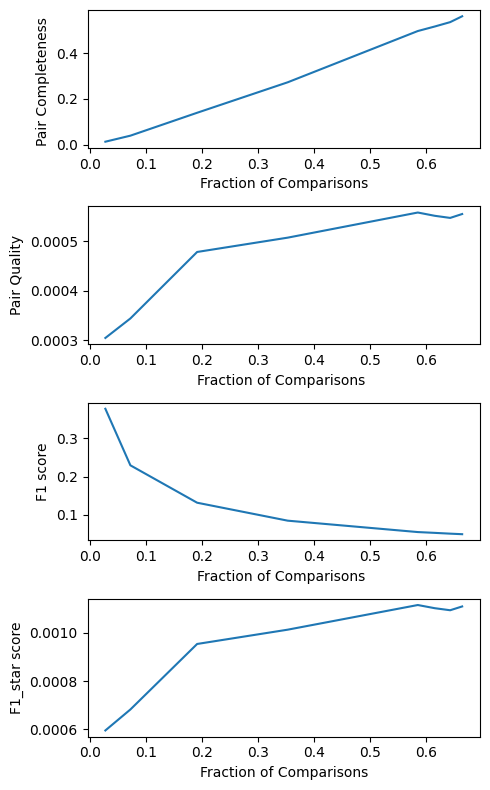

In [ ]:
x = av_measures[4]
y_pc = av_measures[1]
y_pq = av_measures[0]
y_f1 = av_measures[3]
y_f1star = av_measures[2]


# Create subplots with 3 rows and 1 column
fig, axs = plt.subplots(4, 1, figsize=(5, 8))

# Plot Pair Completeness
axs[0].plot(x, y_pc)
axs[0].set_xlabel("Fraction of Comparisons")
axs[0].set_ylabel("Pair Completeness ")

# Plot Pair Quality
axs[1].plot(x, y_pq)
axs[1].set_xlabel("Fraction of Comparisons ")
axs[1].set_ylabel("Pair Quality")

# Plot F1 score
axs[2].plot(x, y_f1)
axs[2].set_xlabel("Fraction of Comparisons ")
axs[2].set_ylabel("F1 score")

# Plot F1star score
axs[3].plot(x, y_f1star)
axs[3].set_xlabel("Fraction of Comparisons")
axs[3].set_ylabel("F1_star score")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()